In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json

## Data

### Setup

In [3]:
PATH = Path('data/carvana')
list(PATH.iterdir())

[PosixPath('data/carvana/sample_submission.csv'),
 PosixPath('data/carvana/train_masks.csv'),
 PosixPath('data/carvana/train_masks_png'),
 PosixPath('data/carvana/train_masks-128'),
 PosixPath('data/carvana/test'),
 PosixPath('data/carvana/29bb3ece3180_11.jpg'),
 PosixPath('data/carvana/metadata.csv'),
 PosixPath('data/carvana/train_hq'),
 PosixPath('data/carvana/train-128'),
 PosixPath('data/carvana/train_masks-512'),
 PosixPath('data/carvana/train-1024'),
 PosixPath('data/carvana/models'),
 PosixPath('data/carvana/train_masks'),
 PosixPath('data/carvana/train'),
 PosixPath('data/carvana/train-512'),
 PosixPath('data/carvana/train_masks-1024'),
 PosixPath('data/carvana/tmp')]

In [4]:
MASKS_FN = 'train_masks.csv'
META_FN = 'metadata.csv'
TRAIN_DN = 'train'
MASKS_DN = 'train_masks'

In [5]:
masks_csv = pd.read_csv(PATH/MASKS_FN)
masks_csv.head()

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


In [6]:
meta_csv = pd.read_csv(PATH/META_FN)
meta_csv.head()

,id,year,make,model,trim1,trim2
0,0004d4463b50,2014.0,Acura,TL,TL,w/SE
1,00087a6bd4dc,2014.0,Acura,RLX,RLX,w/Tech
2,000aa097d423,2012.0,Mazda,MAZDA6,MAZDA6,i Sport
3,000f19f6e7d4,2016.0,Chevrolet,Camaro,Camaro,SS
4,00144e887ae9,2015.0,Acura,TLX,TLX,SH-AWD V6 w/Advance Pkg


In [7]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [8]:
CAR_ID = '00087a6bd4dc'

In [9]:
list((PATH/TRAIN_DN).iterdir())[:5]

[PosixPath('data/carvana/train/b58cc561e560_01.jpg'),
 PosixPath('data/carvana/train/6343156803f9_16.jpg'),
 PosixPath('data/carvana/train/d9b2ded58b72_14.jpg'),
 PosixPath('data/carvana/train/7ac210ba75a1_02.jpg'),
 PosixPath('data/carvana/train/1c5748340af8_01.jpg')]

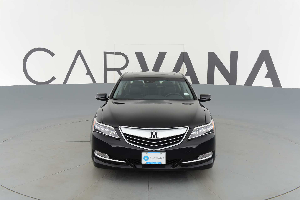

In [10]:
Image.open(PATH/TRAIN_DN/f'{CAR_ID}_01.jpg').resize((300,200))

In [11]:
list((PATH/MASKS_DN).iterdir())[:5]

[PosixPath('data/carvana/train_masks/e5fc2c1c4a8b_06_mask.gif'),
 PosixPath('data/carvana/train_masks/2a4a8964ebf3_11_mask.gif'),
 PosixPath('data/carvana/train_masks/b44091aa62e4_13_mask.gif'),
 PosixPath('data/carvana/train_masks/d1a3af34e674_10_mask.gif'),
 PosixPath('data/carvana/train_masks/245f9c9eab8a_03_mask.gif')]

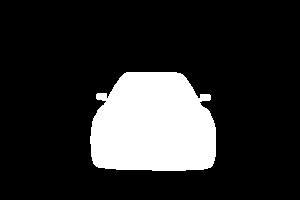

In [12]:
Image.open(PATH/MASKS_DN/f'{CAR_ID}_01_mask.gif').resize((300,200))

In [13]:
ims = [open_image(PATH/TRAIN_DN/f'{CAR_ID}_{i+1:02d}.jpg') for i in range(16)]

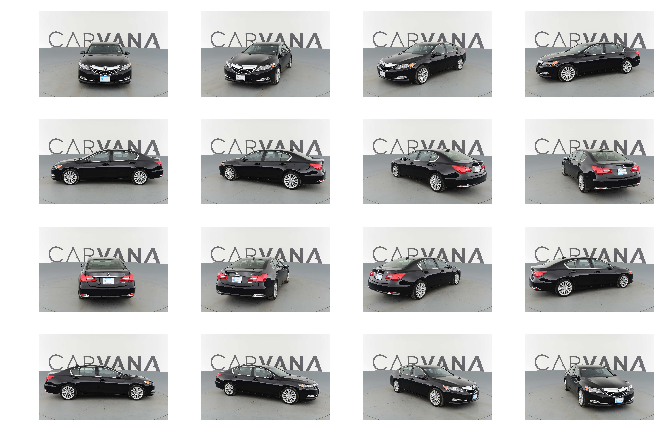

In [14]:
fig, axes = plt.subplots(4, 4, figsize=(9, 6))
for i,ax in enumerate(axes.flat): show_img(ims[i], ax=ax)
plt.tight_layout(pad=0.1)

### Resize and convert

In [ ]:
(PATH/'train_masks_png').mkdir(exist_ok=True)

In [ ]:
def convert_img(fn):
    fn = fn.name
    Image.open(PATH/'train_masks'/fn).save(PATH/'train_masks_png'/f'{fn[:-4]}.png')

In [ ]:
files = list((PATH/'train_masks').iterdir())
with ThreadPoolExecutor(8) as e: e.map(convert_img, files)

In [ ]:
(PATH/'train_masks-128').mkdir(exist_ok=True)

In [ ]:
def resize_mask(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'train_masks-128'/fn.name)

files = list((PATH/'train_masks_png').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_mask, files)

In [ ]:
(PATH/'train-128').mkdir(exist_ok=True)

In [ ]:
def resize_img(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'train-128'/fn.name)

files = list((PATH/'train').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_img, files)

## Dataset

In [15]:
TRAIN_DN = 'train-128'
MASKS_DN = 'train_masks-128'
sz = 128
bs = 64

In [16]:
ims = [open_image(PATH/TRAIN_DN/f'{CAR_ID}_{i+1:02d}.jpg') for i in range(16)]
im_masks = [open_image(PATH/MASKS_DN/f'{CAR_ID}_{i+1:02d}_mask.png') for i in range(16)]

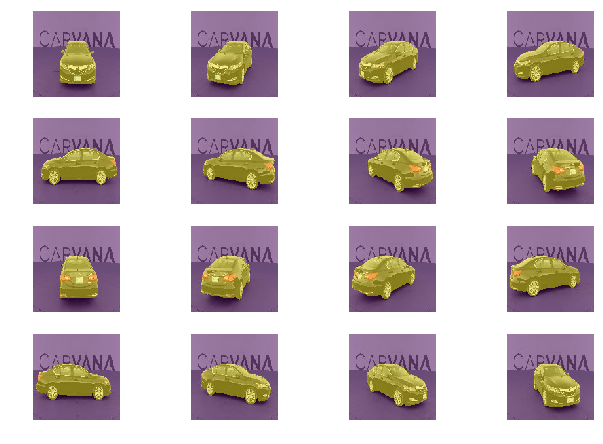

In [17]:
fig, axes = plt.subplots(4, 4, figsize=(9, 6))
for i,ax in enumerate(axes.flat):
    ax = show_img(ims[i], ax=ax)
    show_img(im_masks[i][...,0], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

In [18]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    
    def denorm(self,arr):
        """Reverse the normalization done to a batch of images.

        Arguments:
            arr: of shape/size (N,3,sz,sz)
        """
#         print('Denorm called')
        if type(arr) is not np.ndarray: arr = to_np(arr)
        if len(arr.shape)==3: arr = arr[None]
        return self.transform.denorm(np.rollaxis(arr,1,4))
    
    def get_c(self): 
#         print(self.y.shape) 
        return 0

In [19]:
x_names = np.array([Path(TRAIN_DN)/o for o in masks_csv['img']])
y_names = np.array([Path(MASKS_DN)/f'{o[:-4]}_mask.png' for o in masks_csv['img']])

In [20]:
len(x_names)//16//5*16

1008

In [21]:
val_idxs = list(range(1008))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
len(val_x),len(trn_x)

(1008, 4080)

In [22]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.PIXEL),
            RandomFlip(tfm_y=TfmType.PIXEL),
            RandomLighting(0.05, 0.05)]
# aug_tfms = []

In [23]:
tfms = tfms_from_model(vgg16, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)

In [24]:
denorm = md.trn_ds.denorm
x,y = next(iter(md.aug_dl))
x = denorm(x)

using custom map function


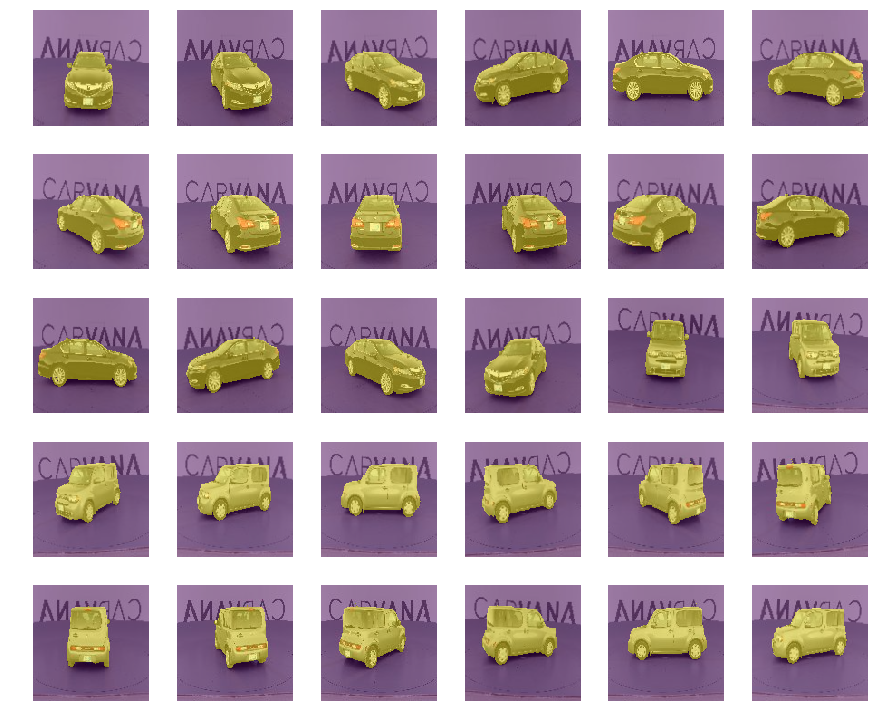

In [25]:
fig, axes = plt.subplots(5, 6, figsize=(12, 10))
for i,ax in enumerate(axes.flat):
    ax=show_img(x[i], ax=ax)
    show_img(y[i][...,0], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

In [26]:
np.average(y[0, :, :, 0] == y[0, :, :, 2])

1.0

In [27]:
x1,y1 = next(iter(md.trn_dl))

using custom map function


## Model

In [28]:
class Empty(nn.Module): 
    def forward(self,x): return x

models = ConvnetBuilder(vgg16, 0, 0, 0, custom_head=Empty())
learn = ConvLearner(md, models)
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('trainable', False),
                           ('nb_params', 1792)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 128, 128]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 128, 128]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 64, 128, 128]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('trainable', False),
                           ('nb_params', 36928)])),
             ('BatchNorm2d-5',

In [29]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [30]:
simple_up = nn.Sequential(
    nn.ReLU(),
    StdUpsample(512,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    nn.ConvTranspose2d(256, 1, 2, stride=2)
)

In [31]:
def mask_loss(pred,targ):
    return F.binary_cross_entropy_with_logits(pred[:,0],targ[...,0])

def mask_acc(pred,targ): return accuracy_multi(pred[:,0], targ[...,0], 0.5)

In [32]:
models = ConvnetBuilder(vgg16, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=mask_loss
learn.metrics=[mask_acc]

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 88%|████████▊ | 56/64 [00:13<00:01,  4.12it/s, loss=1.78] 

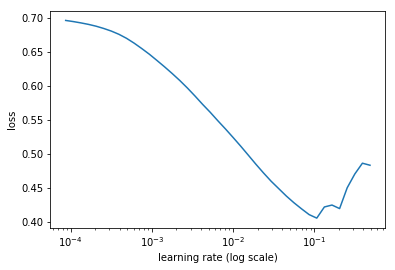

In [33]:
learn.lr_find()
learn.sched.plot()

In [34]:
lr=4e-2

In [35]:
learn.fit(lr,1,cycle_len=5,use_clr=(20,5))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

 38%|███▊      | 24/64 [00:05<00:09,  4.01it/s, loss=0.258]

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



using custom map function                                  
epoch      trn_loss   val_loss   mask_acc   
    0      0.145798   0.112422   0.956376  
  0%|          | 0/64 [00:00<?, ?it/s]using custom map function
using custom map function                                  
    1      0.100771   0.094866   0.953793  
  0%|          | 0/64 [00:00<?, ?it/s]using custom map function
using custom map function                                   
    2      0.085687   0.085324   0.965056  
  0%|          | 0/64 [00:00<?, ?it/s]using custom map function
using custom map function                                   
    3      0.076269   0.077171   0.965834  
  0%|          | 0/64 [00:00<?, ?it/s]using custom map function
using custom map function                                   
    4      0.069601   0.07423    0.968678  



[0.074229665, 0.9686782546341419]

In [ ]:
learn.save('vgg-tmp')

In [ ]:
learn.load('vgg-tmp')

In [ ]:
py,ay = learn.predict_with_targs()

In [ ]:
ay[0].shape

In [ ]:
ay_d = denorm(ay)

In [ ]:
ay_roll = np.rollaxis(ay, 1, 4)

In [ ]:
plt.imshow(ay_roll[0])

In [ ]:
show_img(py[0][0]>0);

In [ ]:
learn.unfreeze()

In [ ]:
learn.bn_freeze(True)

In [ ]:
lrs = np.array([lr/100,lr/10,lr])/4

In [ ]:
learn.fit(lrs,1,cycle_len=40,use_clr=(20,10))

In [ ]:
learn.save('vgg-0')

In [ ]:
learn.load('vgg-0')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [ ]:
ax = show_img(denorm(x)[0])
show_img(py[0][0]>0, ax=ax, alpha=0.5);

In [ ]:
ax = show_img(denorm(x)[0])
show_img(y[0,...,-1], ax=ax, alpha=0.5);

## 512x512

In [ ]:
TRAIN_DN = 'train'
MASKS_DN = 'train_masks_png'
sz = 512
bs = 16

In [ ]:
x_names = np.array([Path(TRAIN_DN)/o for o in masks_csv['img']])
y_names = np.array([Path(MASKS_DN)/f'{o[:-4]}_mask.png' for o in masks_csv['img']])

In [ ]:
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
len(val_x),len(trn_x)

In [ ]:
tfms = tfms_from_model(vgg16, sz, crop_type=CropType.NO, tfm_y=TfmType.PIXEL, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)

In [ ]:
denorm = md.trn_ds.denorm
x,y = next(iter(md.aug_dl))
x = denorm(x)
y = denorm(y)

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    ax=show_img(x[i], ax=ax)
    show_img(y[i][...,0], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

In [ ]:
simple_up = nn.Sequential(
    nn.ReLU(),
    StdUpsample(512,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    nn.ConvTranspose2d(256, 1, 2, stride=2),
)

In [ ]:
models = ConvnetBuilder(vgg16, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=mask_loss
learn.metrics=[mask_acc]

In [ ]:
learn.load('0')

In [ ]:
learn.lr_find()
learn.sched.plot()

In [ ]:
lr=4e-2

In [ ]:
learn.fit(lr,1,cycle_len=5,use_clr=(20,5))

In [ ]:
learn.save('vgg-tmp')

In [ ]:
learn.load('vgg-tmp')

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
lrs = np.array([lr/100,lr/10,lr])/4

In [ ]:
learn.fit(lrs,1,cycle_len=8,use_clr=(20,8))

In [ ]:
learn.save('vgg-512')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [ ]:
ax = show_img(denorm(x)[0])
show_img(py[0][0]>0, ax=ax, alpha=0.5);

In [ ]:
ax = show_img(denorm(x)[0])
show_img(y[0,...,-1], ax=ax, alpha=0.5);

## 1024x1024

In [ ]:
sz = 1024
bs = 4

In [ ]:
tfms = tfms_from_model(vgg16, sz, crop_type=CropType.NO, tfm_y=TfmType.PIXEL, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=4, classes=None)

In [ ]:
denorm = md.trn_ds.denorm
x,y = next(iter(md.aug_dl))
x = denorm(x)

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    ax=show_img(x[i], ax=ax)
    show_img(y[i][...,0], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

In [ ]:
simple_up = nn.Sequential(
    nn.ReLU(),
    StdUpsample(512,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    nn.ConvTranspose2d(256, 1, 2, stride=2),
)

In [ ]:
models = ConvnetBuilder(vgg16, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=mask_loss
learn.metrics=[mask_acc]

In [ ]:
learn.load('512')

In [ ]:
learn.lr_find()
learn.sched.plot()

In [ ]:
lr=4e-2

In [ ]:
learn.fit(lr,1,cycle_len=2,use_clr=(20,4))

In [ ]:
learn.save('vgg-tmp')

In [ ]:
learn.load('vgg-tmp')

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
lrs = np.array([lr/100,lr/10,lr])/8

In [ ]:
learn.fit(lrs,1,cycle_len=4,use_clr=(20,8))

In [ ]:
learn.fit(lrs,1,cycle_len=40,use_clr=(20,10))

In [ ]:
learn.save('1024')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [ ]:
ax = show_img(denorm(x)[0])
show_img(py[0][0]>0, ax=ax, alpha=0.5);

In [ ]:
ax = show_img(denorm(x)[0])
show_img(y[0,...,-1], ax=ax, alpha=0.5);

In [ ]:
show_img(py[0][0]>0);

In [ ]:
show_img(y[0,...,-1]);

## Fin

In [ ]:
x,y = next(iter(md.val_dl))

In [ ]:
py = to_np(learn.model(V(x)))

In [ ]:
ax = show_img(denorm(x)[0])
show_img(py[0][0]>0, ax=ax, alpha=0.5);

In [ ]:
ax = show_img(denorm(x)[0])
